# Imports

In [2]:
%load_ext jupyter_black
%matplotlib inline

In [3]:
import re
import optuna
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from plotly.io import show
from typing import Optional
from optuna.samplers import TPESampler
from sklearn.model_selection import KFold
from wordcloud import WordCloud, STOPWORDS
from lightgbm import LGBMRegressor as lgbm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse, r2_score
from sklearn.model_selection import train_test_split, cross_val_score

sns.set_theme(style="darkgrid")
warnings.filterwarnings("ignore")


def rmse(a, b):
    return mse(a, b, squared=False)

# Input Datasets

In [4]:
train = pd.read_csv("inputs/train.csv").drop(columns="id")
test = pd.read_csv("inputs/test.csv").drop(columns="id")
submission = pd.read_csv("inputs/sample_submission.csv")

print(f"Train Dataset Size : {train.shape} \nTest Dataset Size : {test.shape}")

Train Dataset Size : (1117957, 21) 
Test Dataset Size : (745305, 20)


In [5]:
train.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,5,8,5,8,6,4,4,3,3,4,...,5,3,3,5,4,7,5,7,3,0.445
1,6,7,4,4,8,8,3,5,4,6,...,7,2,0,3,5,3,3,4,3,0.450
2,6,5,6,7,3,7,1,5,4,5,...,7,3,7,5,6,8,2,3,3,0.530
3,3,4,6,5,4,8,4,7,6,8,...,2,4,7,4,4,6,5,7,5,0.535
4,5,3,2,6,4,4,3,3,3,3,...,2,2,6,6,4,1,2,3,5,0.415


In [6]:
test.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors
0,4,6,3,5,6,7,8,7,8,4,8,5,7,5,6,3,6,4,4,5
1,4,4,2,9,5,5,4,7,5,4,2,4,7,4,5,1,7,4,4,3
2,1,3,6,5,7,2,4,6,4,2,7,9,2,5,5,2,3,6,8,3
3,2,4,4,6,4,5,4,3,4,4,7,8,4,6,7,6,4,2,4,4
4,6,3,2,4,6,4,5,5,3,7,4,3,2,6,4,6,8,4,5,5


In [7]:
def plot_countplot(
    train: pd.DataFrame,
    test: Optional[pd.DataFrame],
    col: str,
    topN: Optional[int] = None,
) -> None:
    """
    Plots count plots of a specified column from the training and optionally the test dataset.

    Args:
        train (pd.DataFrame): The training dataset.
        test (Optional[pd.DataFrame]): The test dataset. If None, only the training dataset is plotted.
        col (str): The column to plot the count plot for.
        topN (Optional[int]): Limits the plot to the top N categories if provided.

    Returns:
        None
    """
    train_order = train[col].value_counts().index

    if test is not None:
        test_order = test[col].value_counts().index

    if topN:
        train_order = train_order[0:topN]
        test_order = test_order[0:topN]

    if test is not None:
        r = 1
        c = 2
        s = (22, 3)
    else:
        r = 1
        c = 1
        s = (11, 6)

    fig, axes = plt.subplots(r, c, figsize=s)
    if test is not None:
        sns.countplot(data=train, x=col, ax=axes[0], order=train_order)
        sns.countplot(data=test, x=col, ax=axes[1], order=test_order)
        axes[0].set_title(f"{col} in Train Dataset")
        axes[1].set_title(f"{col} in Test Dataset")
        plt.setp(axes[0].get_xticklabels(), rotation=60, ha="right")
        plt.setp(axes[1].get_xticklabels(), rotation=60, ha="right")
        plt.show()
    else:
        sns.countplot(data=train, x=col, ax=axes, order=train_order)
        axes.set_title(f"{col} in Train Dataset")
        plt.setp(axes.get_xticklabels(), rotation=60, ha="right")
        plt.show()


def plot_distplot(train: pd.DataFrame, test: pd.DataFrame, col: str) -> None:
    """
    Plots the distribution of a specified column for the training and test datasets using histograms.

    Args:
        train (pd.DataFrame): The training dataset.
        test (pd.DataFrame): The test dataset.
        col (str): The column to plot the distribution for.

    Returns:
        None
    """
    fig, axes = plt.subplots(1, 2, figsize=(22, 6))
    sns.histplot(train[col], ax=axes[0])
    sns.histplot(test[col], ax=axes[1])
    axes[0].set_title(f"{col} distribution in Train Dataset")
    axes[1].set_title(f"{col} distribution in Test Dataset")
    plt.show()

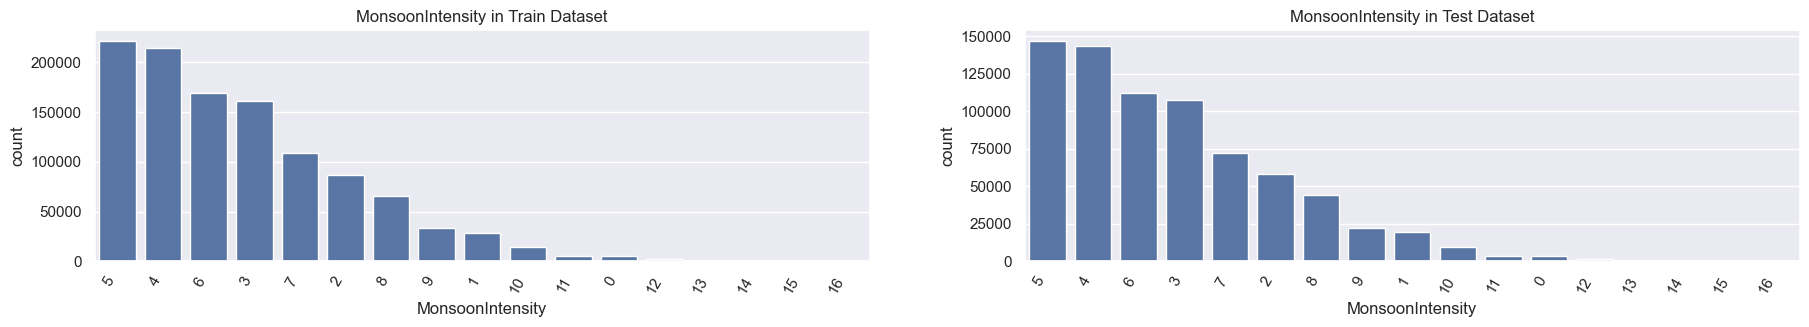

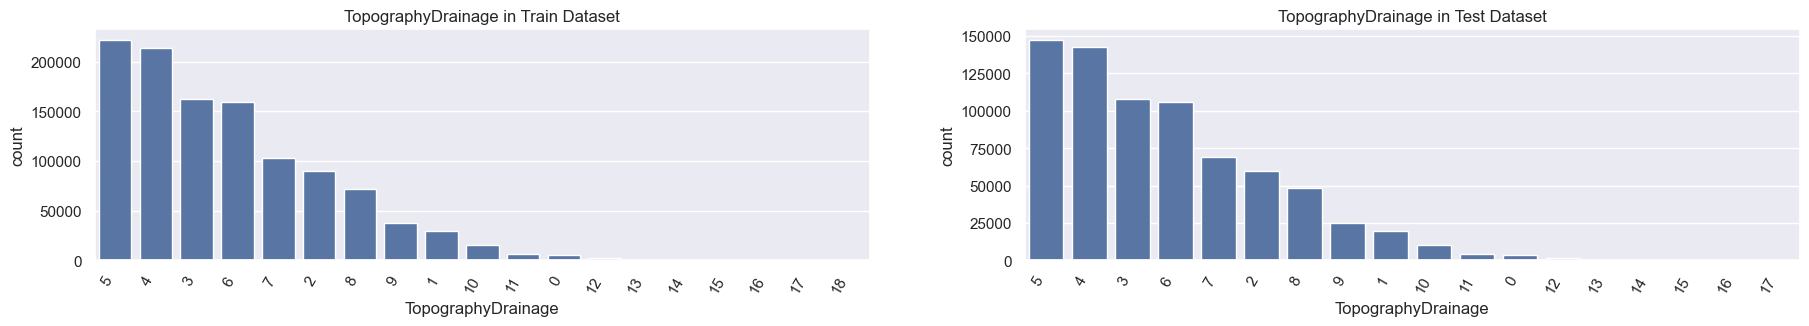

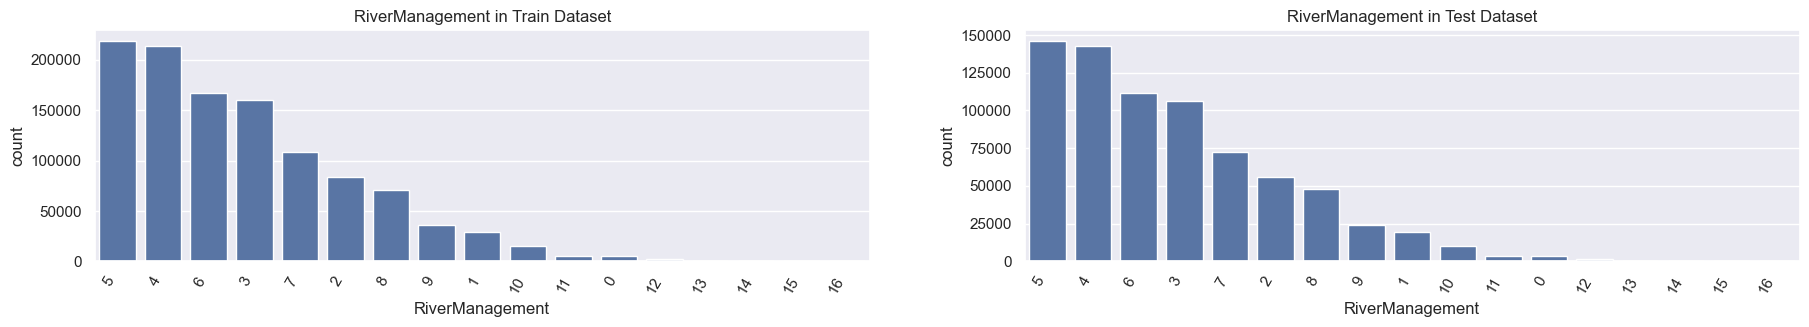

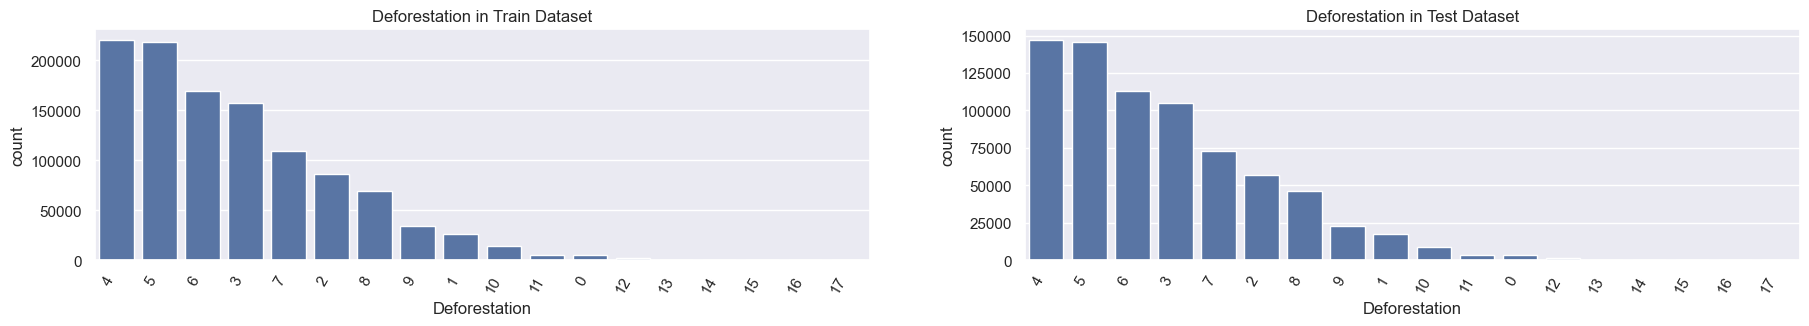

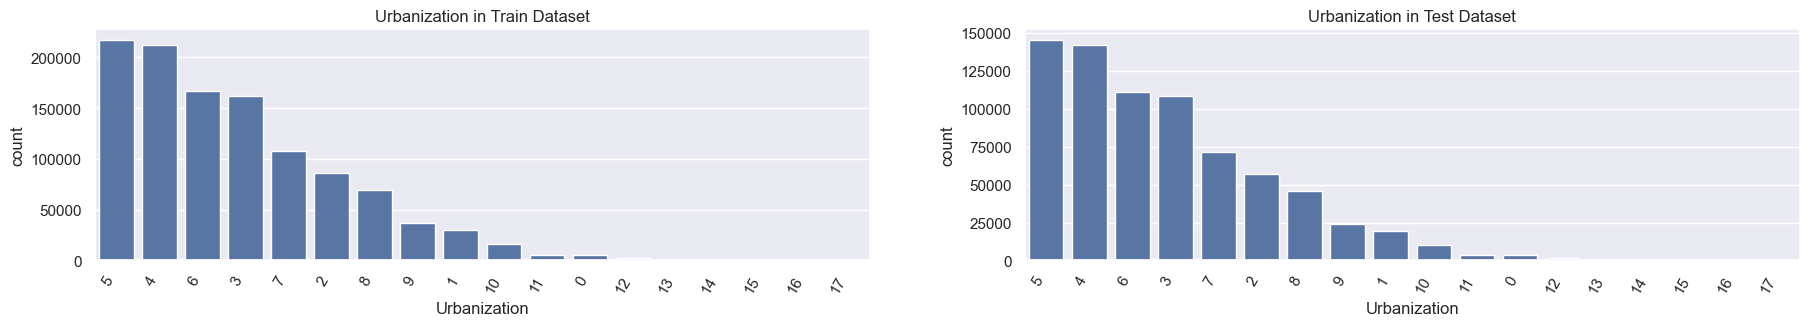

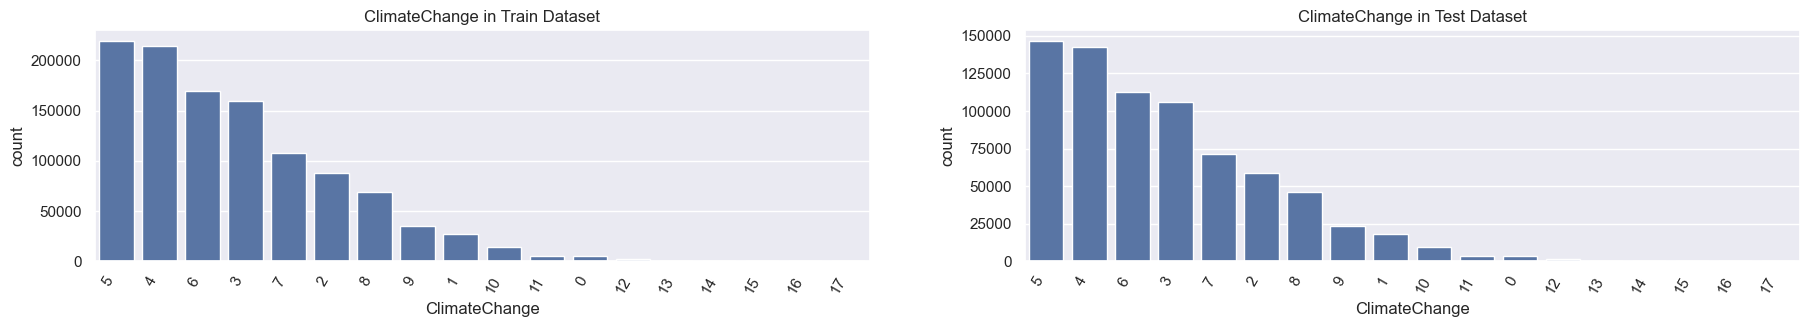

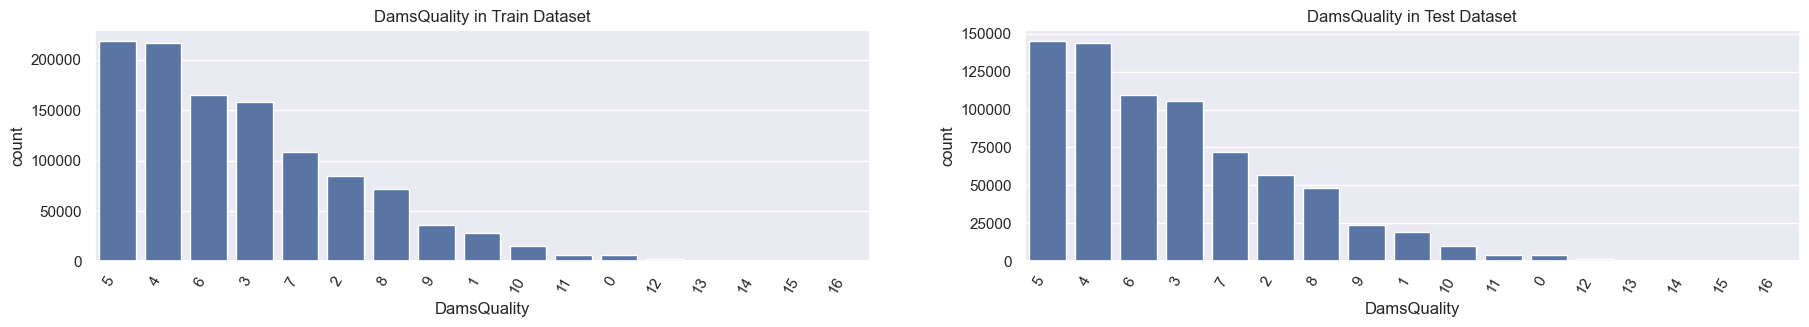

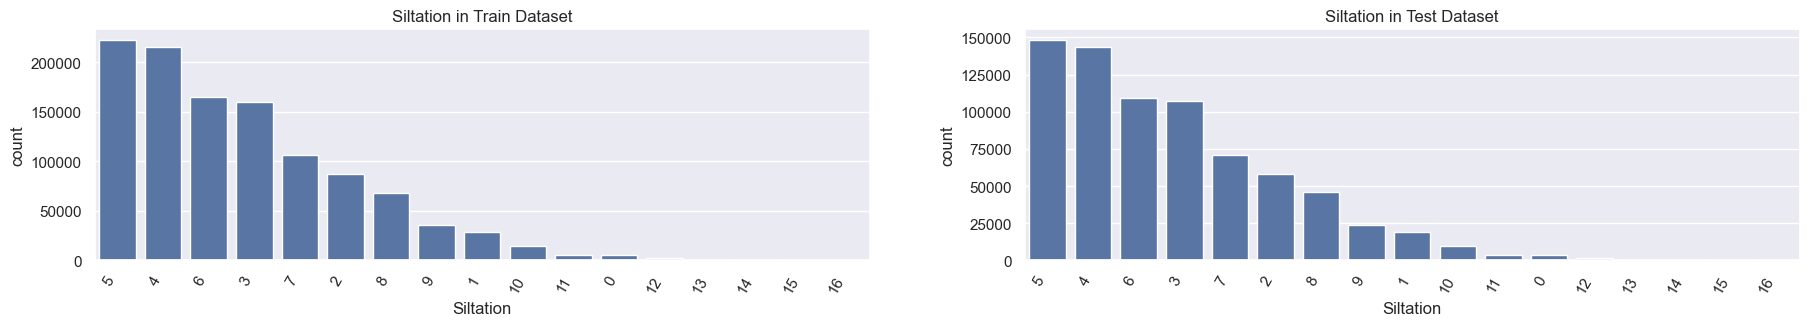

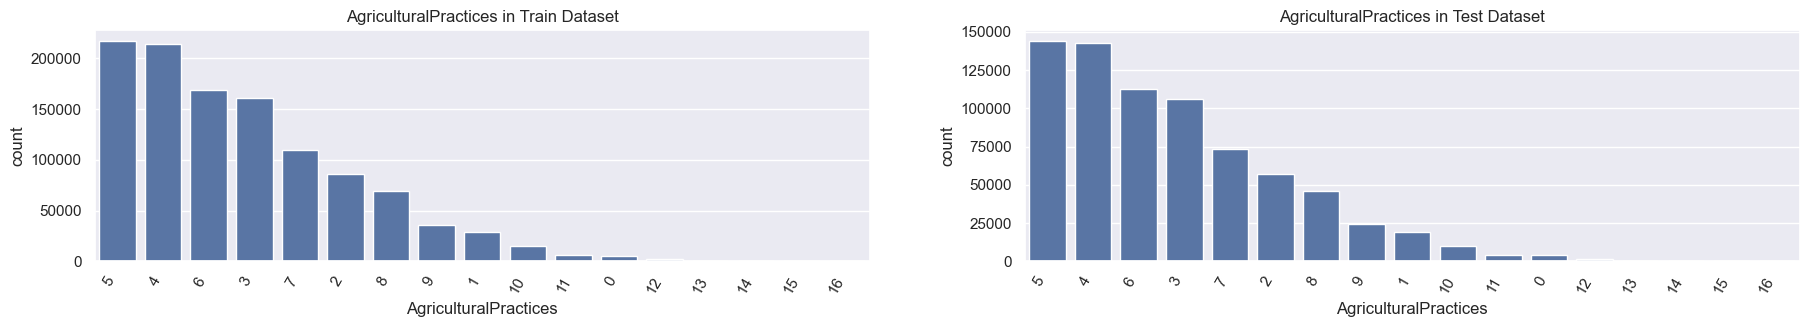

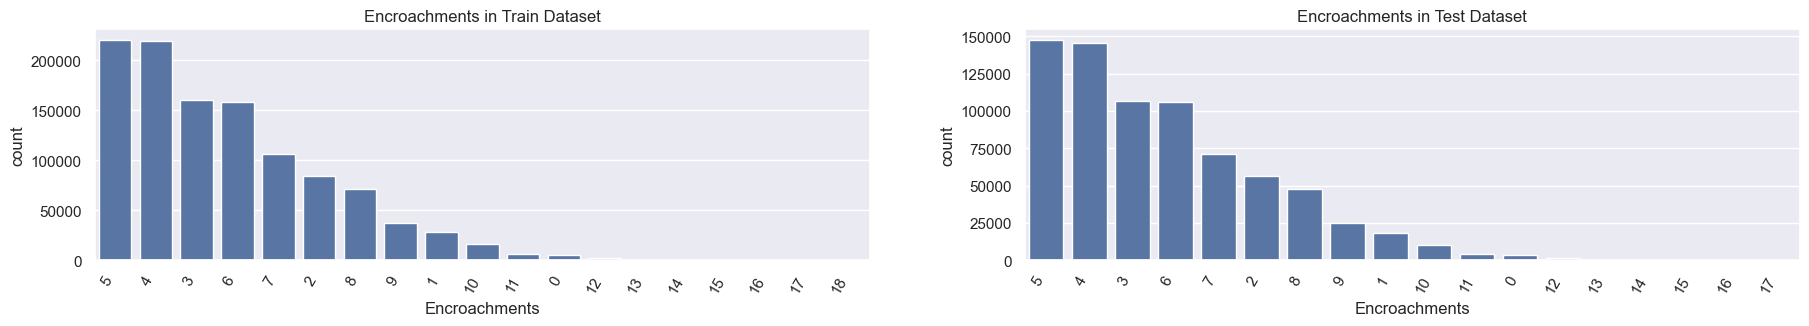

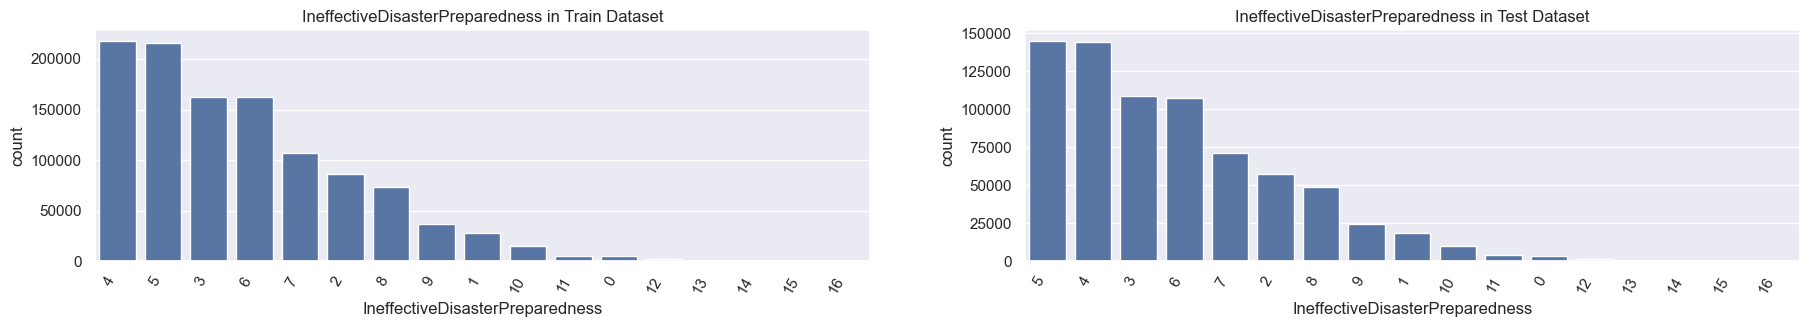

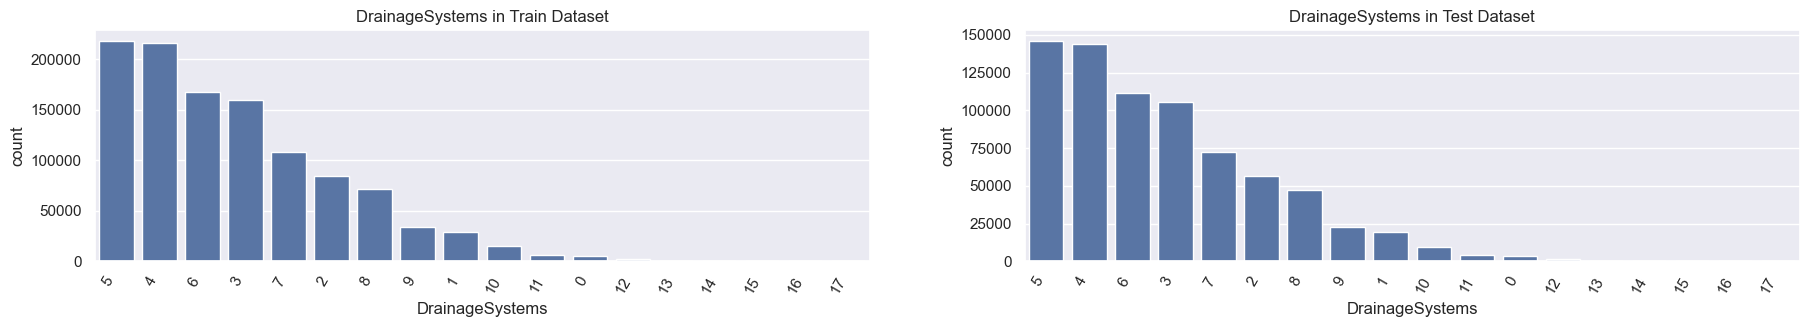

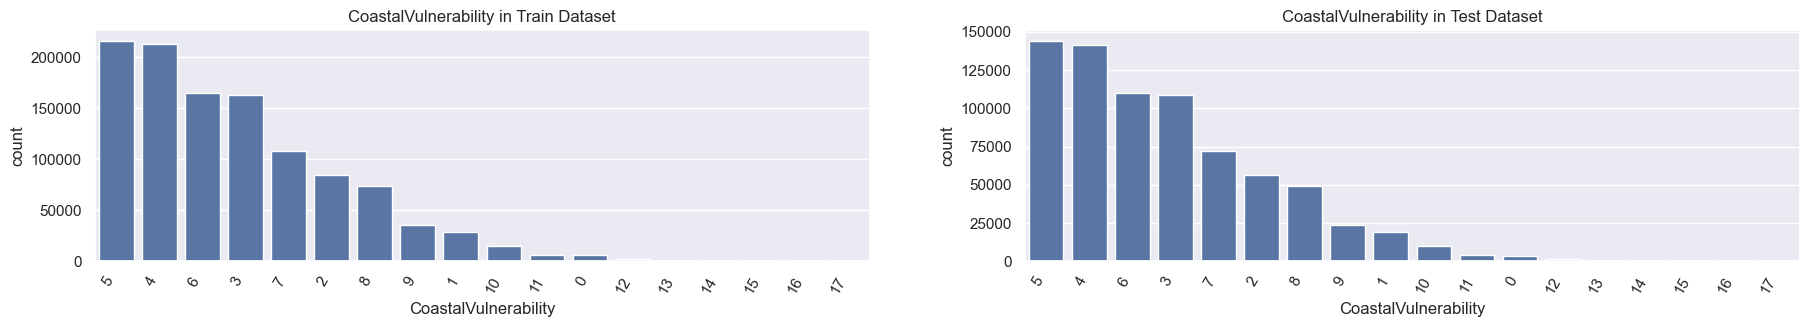

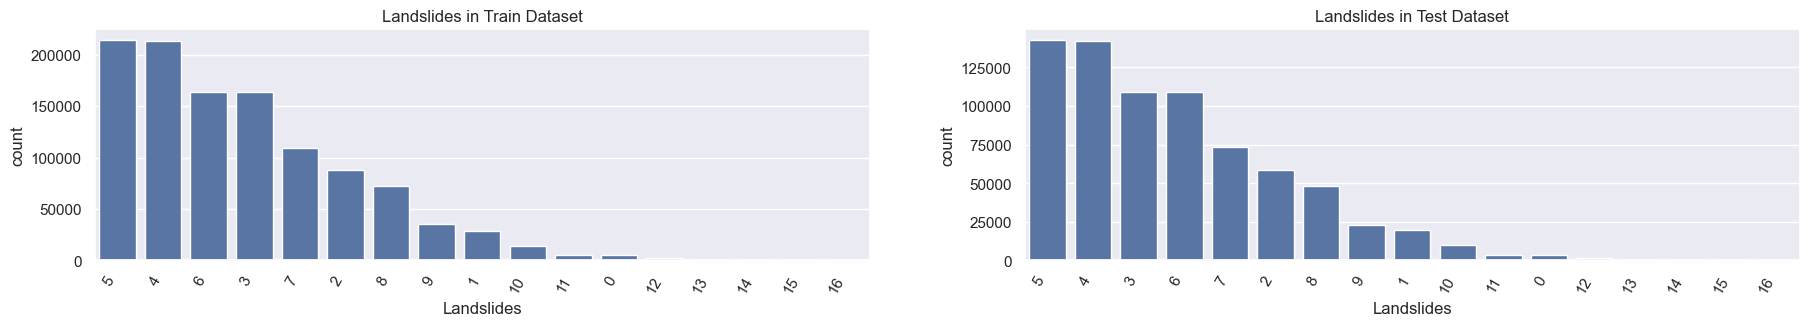

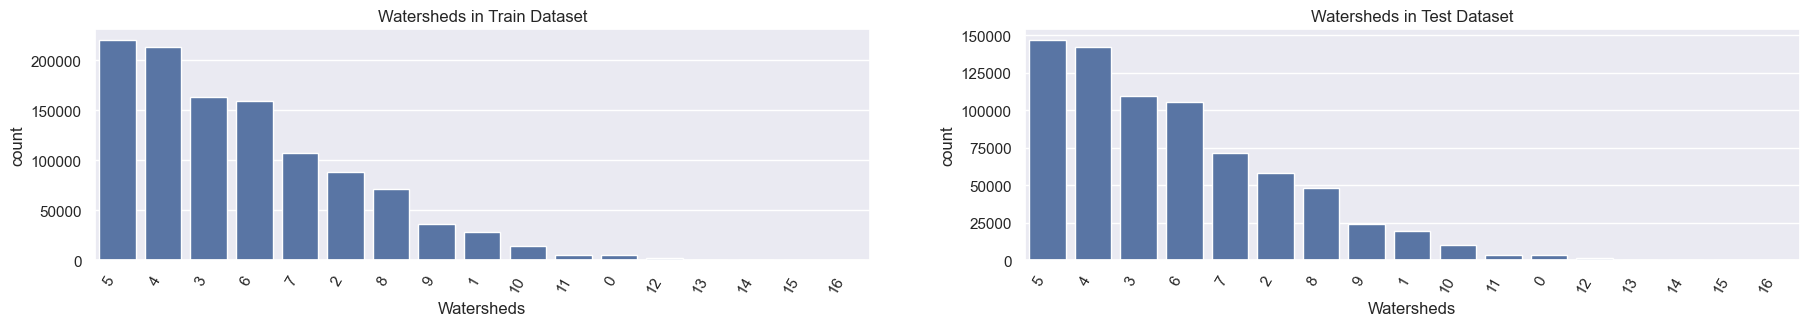

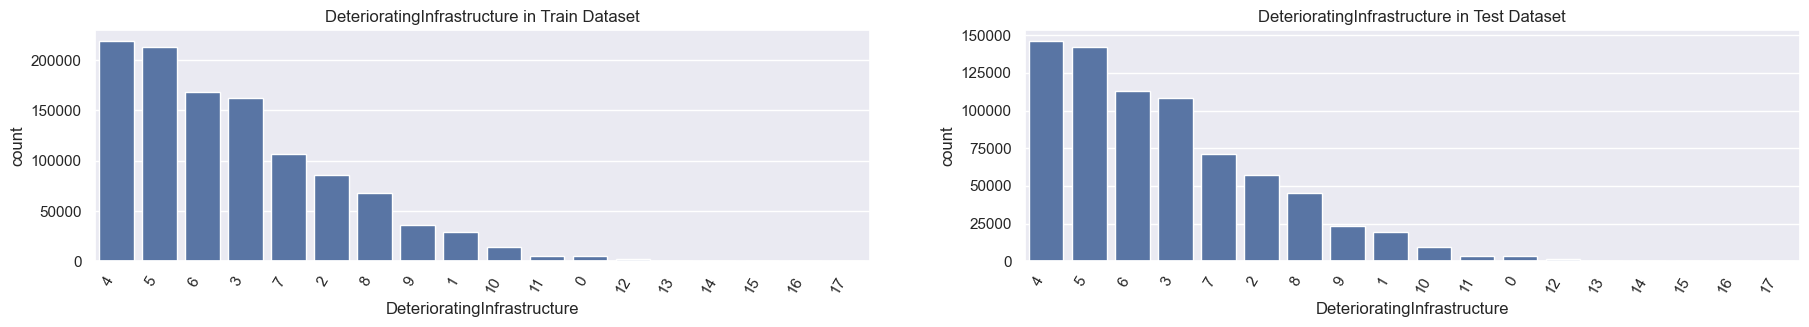

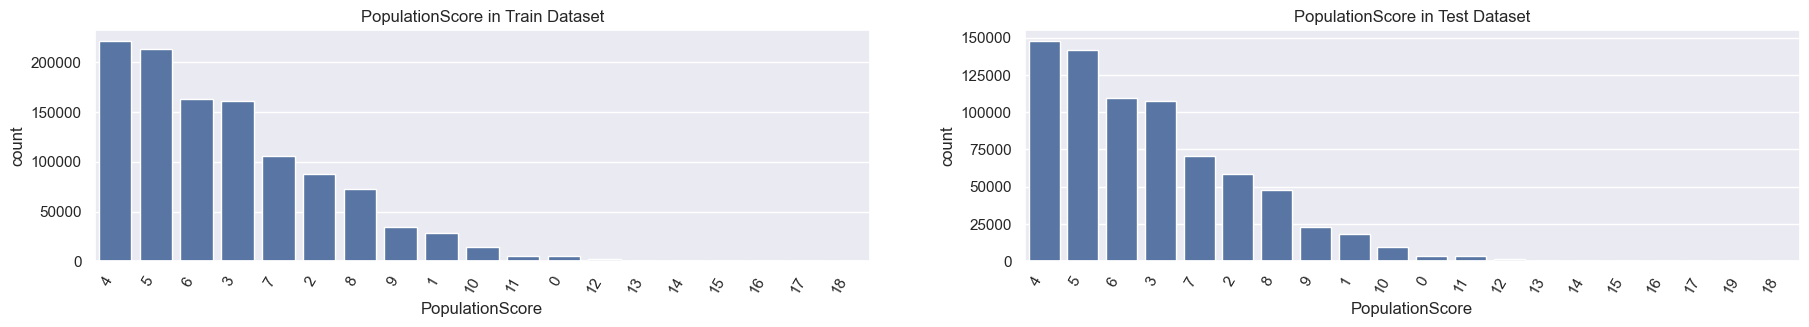

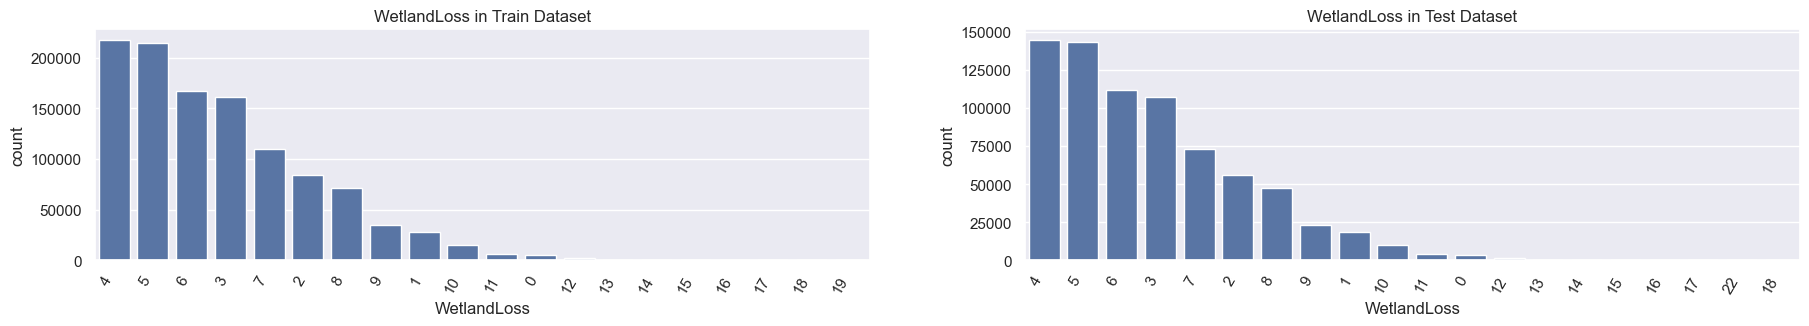

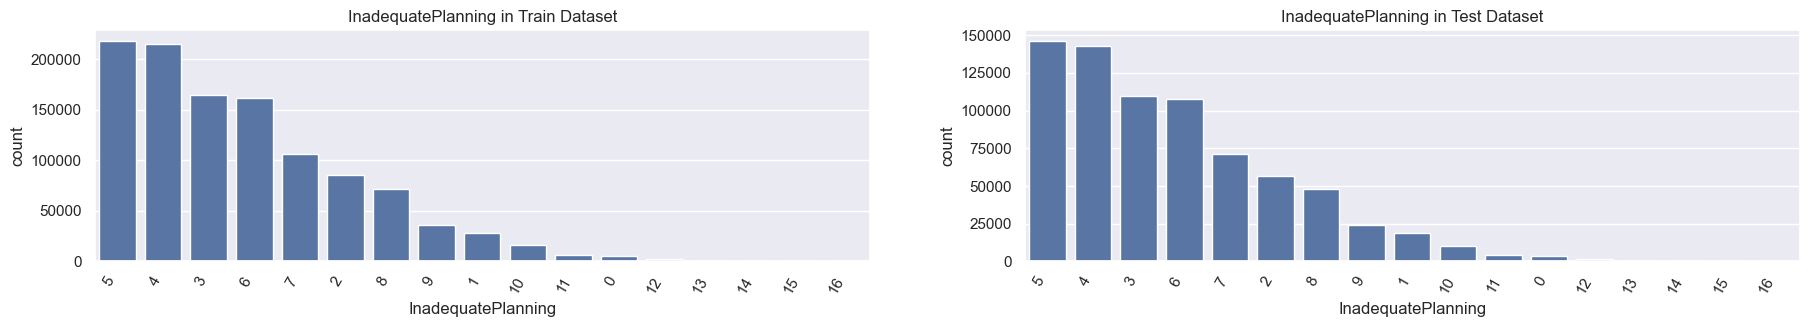

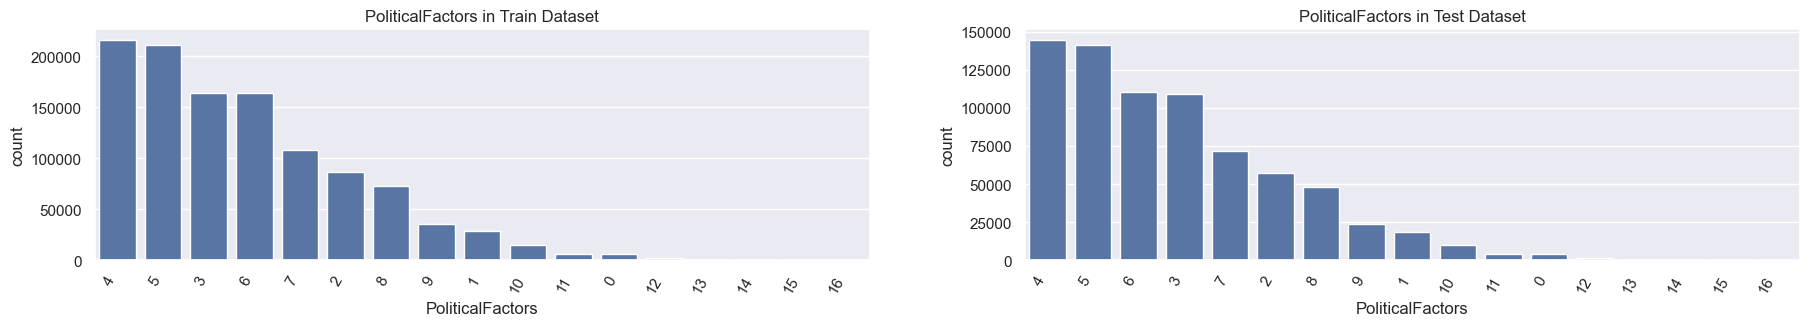

In [8]:
for col in train.drop(columns="FloodProbability").columns:
    plot_countplot(train=train, test=test, col=col)

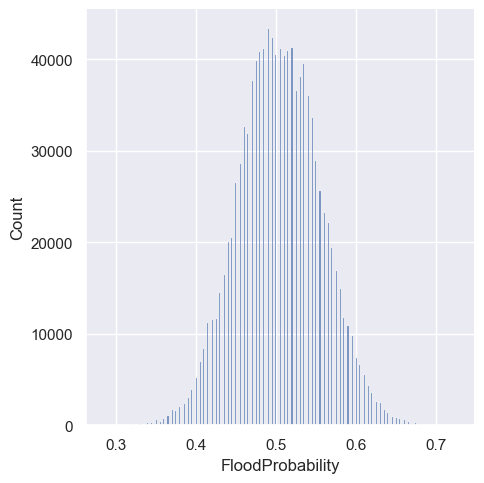

In [9]:
sns.displot(train["FloodProbability"])
plt.show()

# LGBM

In [10]:
def clean_data(df, threshold=100):
    """
    Cleans categorical columns by replacing low-frequency values with 'noise' and filling missing values.

    This function processes categorical columns in the provided dataframe by:
    1. Replacing values that occur less than the specified threshold with the label 'noise'.
    2. Filling missing (NaN) values with the label 'missing'.
    3. Converting the columns to the 'category' data type for memory efficiency and easier handling of categorical data.

    Args:
        df (pd.DataFrame): The dataframe containing the data to be cleaned.
        threshold (int, optional): The minimum frequency threshold for a value to be retained.
                                   Values occurring fewer times than the threshold will be replaced with 'noise'.
                                   Default is 100.

    Returns:
        pd.DataFrame: The cleaned dataframe with updated categorical columns.
    """

    cat_columns = [
        "brand",
        "model",
        "fuel_type",
        "engine",
        "transmission",
        "ext_col",
        "int_col",
        "accident",
        "clean_title",
    ]

    for col in cat_columns:
        value_counts = df[col].value_counts(dropna=False)
        low_freq_mask = df[col].map(value_counts) < threshold
        df.loc[low_freq_mask, col] = "noise"
        df[col] = df[col].fillna("missing").astype("category")

    return df


def k_fold_cv(
    model, X, y, test, k=5, scoring="root_mean_squared_error", random_state=None
):
    """
    Perform K-fold cross-validation for a given model.

    This function applies K-fold cross-validation to a specified model and computes training and validation
    scores for each fold. It also generates predictions for the test dataset by averaging the predictions from each fold.

    Args:
        model: The machine learning model to be trained and validated. It should implement the `fit` and `predict` methods.
        X (pd.DataFrame or np.array): The input features used for training the model.
        y (pd.Series or np.array): The target variable associated with the input features.
        test (pd.DataFrame or np.array): The test dataset on which predictions are made after each fold.
        k (int, optional): The number of folds for K-fold cross-validation. Default is 5.
        scoring (str, optional): The metric used to evaluate model performance. Currently only supports "root_mean_squared_error".
                                 Default is "root_mean_squared_error".
        random_state (int, optional): Controls the randomness of data shuffling. Default is None.

    Returns:
        model: The trained model after cross-validation.
        np.array: The averaged predictions across all folds for the test dataset.

    Prints:
        - Train and validation RMSE for each fold.
        - Mean train and validation scores with their standard deviation across all folds.
    """

    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    train_scores = []
    val_scores = []
    test_predictions = []

    for fold, (train_index, val_index) in enumerate(kf.split(X)):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        if scoring == "rmse":
            train_score = rmse(y_train, y_train_pred)
            val_score = rmse(y_val, y_val_pred)
        elif scoring == "r2":
            train_score = r2_score(y_train, y_train_pred)
            val_score = r2_score(y_val, y_val_pred)
        else:
            raise ValueError(f"Scoring method '{scoring}' not supported.")

        train_scores.append(train_score)
        val_scores.append(val_score)
        print(
            f"Fold {fold + 1}/{k} -> Train {scoring}: {train_score} Val {scoring}: {val_score}"
        )

        # Predict on test set and store for averaging later
        test_predictions.append(model.predict(test))

    print(f"Train Mean Score: {np.mean(train_scores):.4f} ± {np.std(train_scores):.4f}")
    print(f"Val Mean Score: {np.mean(val_scores):.4f} ± {np.std(val_scores):.4f}")

    return model, np.array(test_predictions).mean(axis=0)


def plot_feature_importance(model, feature_names: list) -> None:
    """
    Plots the feature importance for a given model.

    Args:
        model: A trained model that has a `feature_importances_` attribute (e.g., tree-based models like RandomForest, XGBoost, LGBM).
        feature_names (list): List of feature names corresponding to the model input.

    Returns:
        None
    """
    # Get feature importances from the model
    try:
        importances = model.feature_importances_
    except AttributeError:
        raise ValueError("The model does not have a 'feature_importances_' attribute.")

    # Create a DataFrame to pair feature names with their importance
    importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})

    # Sort the DataFrame by feature importance
    importance_df = importance_df.sort_values(by="Importance", ascending=False)

    # Plot the feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
    plt.gca().invert_yaxis()  # Highest importance at the top
    plt.xlabel("Importance")
    plt.title("Feature Importance")
    plt.show()


def actual_vs_pred(actual, pred, xlim=(0, 500000)):
    """
    Plot the distribution of actual vs predicted values with KDE lines.

    This function visualizes the distribution of actual and predicted values
    using histograms with Kernel Density Estimation (KDE) lines overlaid for
    both. The plot helps to compare how closely the predicted values match the
    actual distribution.

    Args:
        actual (array-like): The actual target values.
        pred (array-like): The predicted values from the model.
        xlim (tuple, optional): A tuple to limit the range of the x-axis.
                                Default is (0, 500000).

    Returns:
        None: The function outputs a plot and doesn't return any values.
    """
    # Plot the actual values and predicted values with KDE lines
    sns.histplot(actual, label="Actual", kde=True, alpha=1)
    sns.histplot(pred, label="Predicted", kde=True, alpha=0.3)

    # Set x-axis limits
    plt.xlim(xlim)

    # Add labels and legend
    plt.legend()
    plt.xlabel("Values")
    plt.title("Actual vs Predicted Distribution")

    # Show the plot
    plt.show()

In [11]:
X = train.drop(columns="FloodProbability")
y = train["FloodProbability"]

Fold 1/10 -> Train r2: 0.772308873602572 Val r2: 0.7661879082257916
Fold 2/10 -> Train r2: 0.7725246600652446 Val r2: 0.7663715550266978
Fold 3/10 -> Train r2: 0.7721234815672708 Val r2: 0.7665875086149271
Fold 4/10 -> Train r2: 0.7720508127304919 Val r2: 0.7667046686871372
Fold 5/10 -> Train r2: 0.7720626513750944 Val r2: 0.7672068069434581
Fold 6/10 -> Train r2: 0.7719708274319981 Val r2: 0.7659371510647028
Fold 7/10 -> Train r2: 0.7719351370743858 Val r2: 0.7670303474967017
Fold 8/10 -> Train r2: 0.7725164310267891 Val r2: 0.7657512864763674
Fold 9/10 -> Train r2: 0.7719017369105811 Val r2: 0.7665411880228378
Fold 10/10 -> Train r2: 0.7721822383041844 Val r2: 0.7670089588770669
Train Mean Score: 0.7722 ± 0.0002
Val Mean Score: 0.7665 ± 0.0005


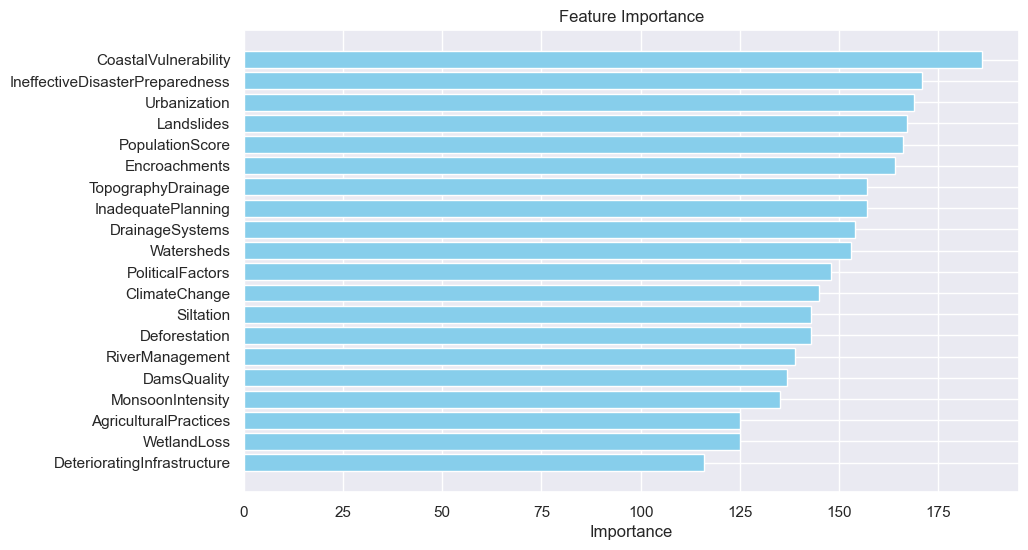

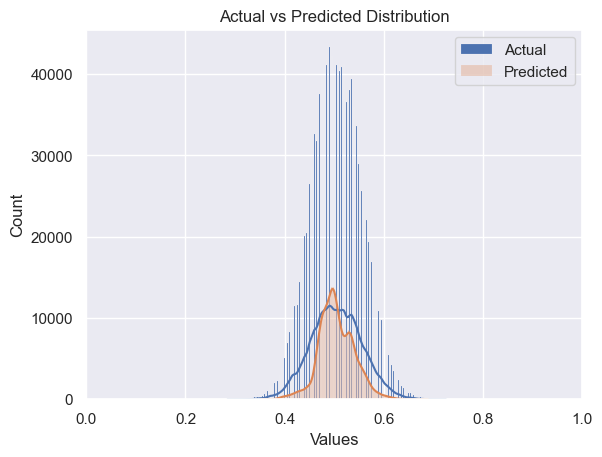

In [11]:
random_state = 42
kfold = 10

model = lgbm(random_state=random_state, verbose=-1)
model, test_prediction = k_fold_cv(
    model,
    X,
    y,
    test,
    k=kfold,
    scoring="r2",
    random_state=random_state,
)

plot_feature_importance(model, X.columns)

actual_vs_pred(y.values, model.predict(X), xlim=(0, 1))

In [12]:
# LB Score = 72697.18383

# Save the modelx
with open("outputs/lgbm_model_base_features_no_hyperP_tune.pkl", "wb") as f:
    pickle.dump(model, f)

# Save the predictions
submission["price"] = test_prediction
submission.to_csv("outputs/lgbm_model_base_features_no_hyperP_tune.csv", index=False)
submission.head()

,id,FloodProbability,price
0,1117957,0.5,0.563156
1,1117958,0.5,0.469071
2,1117959,0.5,0.470687
3,1117960,0.5,0.474191
4,1117961,0.5,0.469409


In [ ]:
#

In [19]:
def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1)
    max_depth = trial.suggest_int("max_depth", 10, 50)
    reg_alpha = trial.suggest_float("reg_alpha", 0.01, 0.1)
    reg_lambda = trial.suggest_float("reg_lambda", 1, 10)
    num_leaves = trial.suggest_int("num_leaves", 50, 300)
    subsample = trial.suggest_float("subsample", 0, 1)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0, 1)

    model = lgbm(
        learning_rate=learning_rate,
        max_depth=max_depth,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        verbose=-1,
    )

    score = cross_val_score(model, X, y, scoring="r2", n_jobs=-1).mean()

    return score


def execute_optuna(n_trials, random_state, study_name):
    if isinstance(n_trials, list):
        n_trials_run = n_trials[1]
        n_trials = sum(n_trials)
    else:
        n_trials_run = n_trials
    storage = "sqlite:///my_study.db"  # Local SQLite database file

    # Create or load a study
    study = optuna.create_study(
        study_name=study_name,
        storage=storage,
        direction="maximize",
        sampler=TPESampler(seed=random_state),
        load_if_exists=True,
    )

    study.optimize(objective, n_trials=n_trials_run)

    # Load the existing study
    study = optuna.load_study(study_name=study_name, storage=storage)

    fig = optuna.visualization.plot_optimization_history(study)
    show(fig)
    fig = optuna.visualization.plot_parallel_coordinate(study)
    show(fig)
    fig = optuna.visualization.plot_param_importances(study)
    show(fig)

    print(f"Best Params: {study.best_params}")

    return study


def run_cv_on_best_study_params(X, y, test, study_params, random_state=42, kfold=10):
    model = lgbm(**study_params, random_state=random_state, verbose=-1)
    model, test_prediction = k_fold_cv(
        model,
        X,
        y,
        test,
        k=kfold,
        scoring="r2",
        random_state=random_state,
    )

    plot_feature_importance(model, X.columns)

    return model, test_prediction


def save_outputs(model, model_name, test_predictions):
    # Save the model
    with open(f"outputs/{model_name}.pkl", "wb") as f:
        pickle.dump(model, f)

    # Save the predictions
    submission["FloodProbability"] = test_predictions
    submission.to_csv(f"outputs/{model_name}.csv", index=False)
    print(submission.head())

In [16]:
n_trials = 20
random_state = 42
kfold = 10

# Define the study name and storage path (local SQLite database file)
study_name = f"lgbm_model_base_features"
storage = "sqlite:///my_study.db"

study = execute_optuna(
    n_trials=n_trials, random_state=random_state, study_name=study_name
)

# Load the existing study
study = optuna.load_study(study_name=study_name, storage=storage)

[I 2024-09-06 13:55:15,454] Using an existing study with name 'lgbm_model_base_features' instead of creating a new one.
[I 2024-09-06 13:55:26,599] Trial 1 finished with value: 0.25519036084142804 and parameters: {'learning_rate': 0.04370861069626263, 'max_depth': 48, 'reg_alpha': 0.07587945476302646, 'reg_lambda': 6.387926357773329, 'num_leaves': 89, 'subsample': 0.15599452033620265, 'colsample_bytree': 0.05808361216819946}. Best is trial 1 with value: 0.25519036084142804.
[I 2024-09-06 13:55:59,239] Trial 2 finished with value: 0.7208492999798967 and parameters: {'learning_rate': 0.08795585311974417, 'max_depth': 34, 'reg_alpha': 0.0737265320016441, 'reg_lambda': 1.185260448662222, 'num_leaves': 293, 'subsample': 0.8324426408004217, 'colsample_bytree': 0.21233911067827616}. Best is trial 2 with value: 0.7208492999798967.
[I 2024-09-06 13:56:32,973] Trial 3 finished with value: 0.5329171727617951 and parameters: {'learning_rate': 0.02636424704863906, 'max_depth': 17, 'reg_alpha': 0.03

Best Params: {'learning_rate': 0.09880401254019672, 'max_depth': 27, 'reg_alpha': 0.0666395799426834, 'reg_lambda': 4.568511220703523, 'num_leaves': 265, 'subsample': 0.5596158930967837, 'colsample_bytree': 0.8415191599116678}


Running K-Fold CV on the Best Study Hyperparameters
Fold 1/10 -> Train r2: 0.834816580809815 Val r2: 0.815370580304257
Fold 2/10 -> Train r2: 0.834929254713968 Val r2: 0.814562760959443
Fold 3/10 -> Train r2: 0.8348390462630876 Val r2: 0.8151846024165939
Fold 4/10 -> Train r2: 0.8349882566324793 Val r2: 0.8146035727116111
Fold 5/10 -> Train r2: 0.8347319335491173 Val r2: 0.8145828768925969
Fold 6/10 -> Train r2: 0.8349217727808351 Val r2: 0.8150744904736631
Fold 7/10 -> Train r2: 0.8348380737236153 Val r2: 0.8157241804705134
Fold 8/10 -> Train r2: 0.8349454673128007 Val r2: 0.8141669116535689
Fold 9/10 -> Train r2: 0.8349215849876244 Val r2: 0.8152054440260417
Fold 10/10 -> Train r2: 0.8348672076741159 Val r2: 0.8158630997598546
Train Mean Score: 0.8349 ± 0.0001
Val Mean Score: 0.8150 ± 0.0005


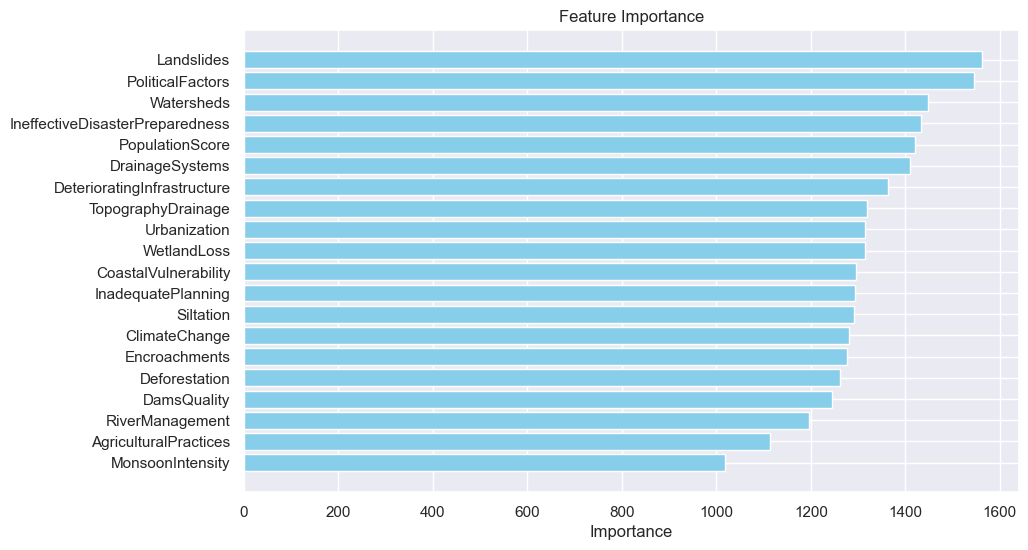

        id  FloodProbability     price
0  1117957               0.5  0.572731
1  1117958               0.5  0.458247
2  1117959               0.5  0.461303
3  1117960               0.5  0.466036
4  1117961               0.5  0.462526


In [17]:
params = study.best_params
print("Running K-Fold CV on the Best Study Hyperparameters")
model, test_prediction = run_cv_on_best_study_params(
    X, y, test, params, random_state=random_state, kfold=kfold
)

save_outputs(
    model=model,
    model_name=f"lgbm_model_base_features_hyperP_tune",
    test_predictions=test_prediction,
)

In [21]:
save_outputs(
    model=model,
    model_name=f"lgbm_model_base_features_hyperP_tune",
    test_predictions=test_prediction,
)

        id  FloodProbability
0  1117957          0.572731
1  1117958          0.458247
2  1117959          0.461303
3  1117960          0.466036
4  1117961          0.462526


In [12]:
num_cols = [
    "MonsoonIntensity",
    "TopographyDrainage",
    "RiverManagement",
    "Deforestation",
    "Urbanization",
    "ClimateChange",
    "DamsQuality",
    "Siltation",
    "AgriculturalPractices",
    "Encroachments",
    "IneffectiveDisasterPreparedness",
    "DrainageSystems",
    "CoastalVulnerability",
    "Landslides",
    "Watersheds",
    "DeterioratingInfrastructure",
    "PopulationScore",
    "WetlandLoss",
    "InadequatePlanning",
    "PoliticalFactors",
]

unique_vals = []
for df in [train, test]:
    for col in num_cols:
        unique_vals += list(df[col].unique())

unique_vals = list(set(unique_vals))


def getFeats(df):

    scaler = StandardScaler()

    df["ClimateAnthropogenicInteraction"] = (
        df["MonsoonIntensity"] + df["ClimateChange"]
    ) * (
        df["Deforestation"]
        + df["Urbanization"]
        + df["AgriculturalPractices"]
        + df["Encroachments"]
    )
    df["InfrastructurePreventionInteraction"] = (
        df["DamsQuality"] + df["DrainageSystems"] + df["DeterioratingInfrastructure"]
    ) * (
        df["RiverManagement"]
        + df["IneffectiveDisasterPreparedness"]
        + df["InadequatePlanning"]
    )

    df["sum"] = df[num_cols].sum(axis=1)
    df["std"] = df[num_cols].std(axis=1)
    df["mean"] = df[num_cols].mean(axis=1)
    df["max"] = df[num_cols].max(axis=1)
    df["min"] = df[num_cols].min(axis=1)
    df["mode"] = df[num_cols].mode(axis=1)[0]
    df["median"] = df[num_cols].median(axis=1)
    df["q_25th"] = df[num_cols].quantile(0.25, axis=1)
    df["q_75th"] = df[num_cols].quantile(0.75, axis=1)
    df["skew"] = df[num_cols].skew(axis=1)
    df["kurt"] = df[num_cols].kurt(axis=1)
    df["sum_72_76"] = df["sum"].isin(np.arange(72, 76))
    for i in range(10, 100, 10):
        df[f"{i}th"] = df[num_cols].quantile(i / 100, axis=1)
    df["harmonic"] = len(num_cols) / df[num_cols].apply(
        lambda x: (1 / x).mean(), axis=1
    )
    df["geometric"] = df[num_cols].apply(lambda x: x.prod() ** (1 / len(x)), axis=1)
    df["zscore"] = (
        df[num_cols].apply(lambda x: (x - x.mean()) / x.std(), axis=1).mean(axis=1)
    )
    df["cv"] = df["std"] / df["mean"]
    df["Skewness_75"] = (
        df[num_cols].quantile(0.75, axis=1) - df[num_cols].mean(axis=1)
    ) / df[num_cols].std(axis=1)
    df["Skewness_25"] = (
        df[num_cols].quantile(0.25, axis=1) - df[num_cols].mean(axis=1)
    ) / df[num_cols].std(axis=1)
    df["2ndMoment"] = df[num_cols].apply(lambda x: (x**2).mean(), axis=1)
    df["3rdMoment"] = df[num_cols].apply(lambda x: (x**3).mean(), axis=1)
    df["entropy"] = df[num_cols].apply(lambda x: -1 * (x * np.log(x)).sum(), axis=1)
    df["MonsoonIntensity_squared"] = df["MonsoonIntensity"] ** 2

    for v in unique_vals:
        if v < 16:
            df["cnt_{}".format(v)] = (df[num_cols] == v).sum(axis=1)
            df["cnt_wtd_{}".format(v)] = ((df["cnt_{}".format(v)]) * v) / df["sum"]

    df[num_cols] = scaler.fit_transform(df[num_cols])

    return df

In [13]:
train_fe = getFeats(df=train.copy())
test_fe = getFeats(df=test.copy())

In [14]:
X = train_fe.drop(columns="FloodProbability")
y = train_fe["FloodProbability"]

In [33]:
n_trials = 20
random_state = 42
kfold = 10

# Define the study name and storage path (local SQLite database file)
study_name = f"lgbm_model_feature_engg"
storage = "sqlite:///my_study.db"

study = execute_optuna(
    n_trials=n_trials, random_state=random_state, study_name=study_name
)

# Load the existing study
study = optuna.load_study(study_name=study_name, storage=storage)

[I 2024-09-06 15:41:19,647] A new study created in RDB with name: lgbm_model_feature_engg
[I 2024-09-06 15:41:54,494] Trial 0 finished with value: 0.861706741217203 and parameters: {'learning_rate': 0.04370861069626263, 'max_depth': 48, 'reg_alpha': 0.07587945476302646, 'reg_lambda': 6.387926357773329, 'num_leaves': 89, 'subsample': 0.15599452033620265, 'colsample_bytree': 0.05808361216819946}. Best is trial 0 with value: 0.861706741217203.
[I 2024-09-06 15:42:56,823] Trial 1 finished with value: 0.868751903415542 and parameters: {'learning_rate': 0.08795585311974417, 'max_depth': 34, 'reg_alpha': 0.0737265320016441, 'reg_lambda': 1.185260448662222, 'num_leaves': 293, 'subsample': 0.8324426408004217, 'colsample_bytree': 0.21233911067827616}. Best is trial 1 with value: 0.868751903415542.
[I 2024-09-06 15:44:10,634] Trial 2 finished with value: 0.8648321488857407 and parameters: {'learning_rate': 0.02636424704863906, 'max_depth': 17, 'reg_alpha': 0.0373818018663584, 'reg_lambda': 5.7228

Best Params: {'learning_rate': 0.07952073910549273, 'max_depth': 26, 'reg_alpha': 0.0666395799426834, 'reg_lambda': 3.1627186782006964, 'num_leaves': 127, 'subsample': 0.15595527417327557, 'colsample_bytree': 0.7871064902468218}


In [17]:
# Define the study name and storage path (local SQLite database file)
study_name = f"lgbm_model_feature_engg"
storage = "sqlite:///my_study.db"


# Load the existing study
study = optuna.load_study(study_name=study_name, storage=storage)

Running K-Fold CV on the Best Study Hyperparameters
Fold 1/10 -> Train r2: 0.8722508324603208 Val r2: 0.8693763818493535
Fold 2/10 -> Train r2: 0.8723010010575435 Val r2: 0.8688915731364198
Fold 3/10 -> Train r2: 0.8721484600219231 Val r2: 0.8706205511918529
Fold 4/10 -> Train r2: 0.8723288475567812 Val r2: 0.8686901723466426
Fold 5/10 -> Train r2: 0.8722575638841975 Val r2: 0.8694127541209699
Fold 6/10 -> Train r2: 0.8723776897424628 Val r2: 0.8684833176799209
Fold 7/10 -> Train r2: 0.8721488197628977 Val r2: 0.870157581240246
Fold 8/10 -> Train r2: 0.8723966246016319 Val r2: 0.8683656932081801
Fold 9/10 -> Train r2: 0.8722906746332015 Val r2: 0.8690337585388643
Fold 10/10 -> Train r2: 0.8722641405700117 Val r2: 0.8696298790248269
Train Mean Score: 0.8723 ± 0.0001
Val Mean Score: 0.8693 ± 0.0007


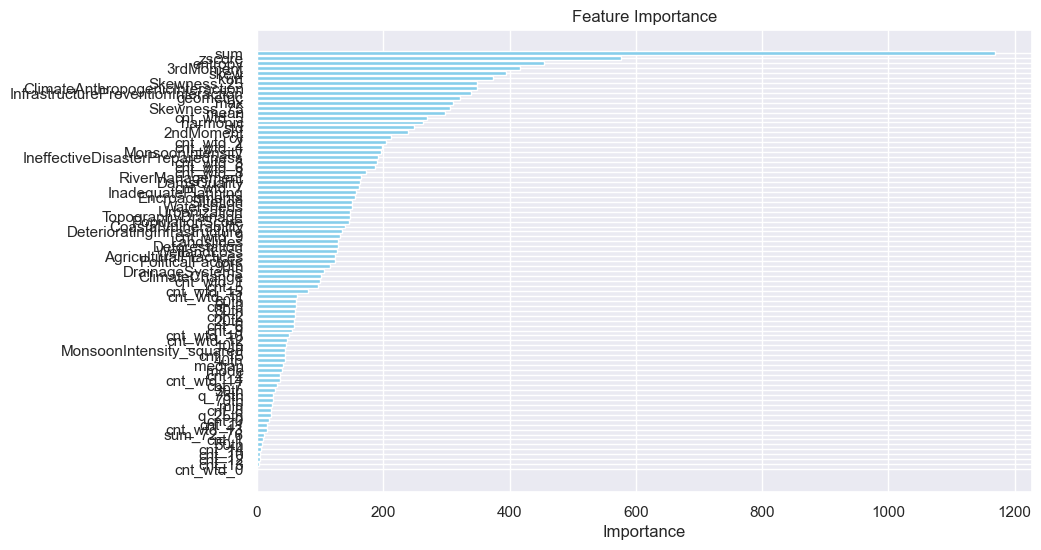

        id  FloodProbability
0  1117957          0.577688
1  1117958          0.456997
2  1117959          0.449084
3  1117960          0.465925
4  1117961          0.467104


In [21]:
n_trials = 20
random_state = 42
kfold = 10

params = study.best_params
print("Running K-Fold CV on the Best Study Hyperparameters")
model, test_prediction = run_cv_on_best_study_params(
    X, y, test_fe, params, random_state=random_state, kfold=kfold
)

save_outputs(
    model=model,
    model_name=f"lgbm_model_feature_engg_hyperP_tune",
    test_predictions=test_prediction,
)

In [22]:
save_outputs(
    model=model,
    model_name=f"lgbm_model_feature_engg_hyperP_tune",
    test_predictions=test_prediction,
)

        id  FloodProbability
0  1117957          0.577688
1  1117958          0.456997
2  1117959          0.449084
3  1117960          0.465925
4  1117961          0.467104
